# Nb3X8 Hubbard-I Calculation

In [1]:
################################################################################
#
# triqs_Nb3X8_Hubbard-I: Calculation pipeline for Hubbard-I for Nb3X8
#
# Copyright (C) 2025, Joost Aretz, Sergii Grytsiuk, Malte Rösner, Hugo U. R. Strand
#
################################################################################
#
# Based on and inspired by the TRIQS/tprf dmft pipeline
#
# Copyright (C) 2019 by The Simons Foundation
# Author: H. U.R. Strand
#
# https://github.com/TRIQS/tprf/blob/3.3.x/doc/user_guide/dmft_susceptibility/calc_sc.py
#
################################################################################
#
# triqs_Nb3X8_Hubbard-I is free software: you can redistribute it and/or modify it under the
# terms of the GNU General Public License as published by the Free Software
# Foundation, either version 3 of the License, or (at your option) any later
# version.
#
# triqs_Nb3X8_Hubbard-I is distributed in the hope that it will be useful, but WITHOUT ANY
# WARRANTY; without even the implied warranty of MERCHANTABILITY or FITNESS
# FOR A PARTICULAR PURPOSE. See the GNU General Public License for more
# details.
#
# You should have received a copy of the GNU General Public License along with
# triqs_Nb3X8_Hubbard-I. If not, see <http://www.gnu.org/licenses/>.
#
################################################################################
import numpy as np
import matplotlib.pylab as plt

from triqs.gf import *
from triqs.operators import *
from triqs.operators.util.hamiltonians import h_int_slater
from triqs_hubbardI import *

from triqs_tprf.ParameterCollection import ParameterCollection
from triqs_tprf.tight_binding import TBLattice
from triqs_tprf.wannier90 import parse_hopping_from_wannier90_hr_dat
from triqs_tprf.wannier90 import parse_lattice_vectors_from_wannier90_wout
from triqs_tprf.wannier90 import parse_reciprocal_lattice_vectors_from_wannier90_wout
from triqs_tprf.lattice_utils import k_space_path
from triqs_tprf.lattice import lattice_dyson_g_fk, lattice_dyson_g_w

Starting serial run at: 2026-01-29 13:16:36.013033


## Helper Functions

In [2]:
def plot_spectralfunc(g_fk, pathAng, kx, ky, kz):
    fmesh = g_fk.mesh[0]
    A0_fk_interper = np.vectorize(lambda w, kx, ky, kz : np.trace(-1.0*g_fk[w,:]([kx, ky, kz])[:,:]).imag)
    A0_fk_interp = []
    for w in fmesh:
        A0_fk_interp += [A0_fk_interper(w, kx, ky, kz)]    
    XX, YY = np.meshgrid(pathAng, list(fmesh.values()))
    ZZ = A0_fk_interp
    return(np.array([XX,YY,ZZ]))

def read_uijkl(file, nb):
    uijkl = np.zeros((nb,nb,nb,nb),dtype=np.float64)
    with open(file, 'r') as f: 
        data = f.readlines()
        for i in range(len(data)):
            if '#' not in data[i]: 
                ll = data[i]
                ii = np.asfarray(ll.split()[:4],int).astype(int) - np.array([1,1,1,1]) 
                uijkl[ii[0],ii[2],ii[1],ii[3]]=float(ll.split()[4])
    return uijkl

## Settings

In [6]:
# available materials
material = ["0_Nb3F8", "1_Nb3Cl8", "2_Nb3Br8", "3_Nb3I8"]

# chemical potentials in order of material list
mu_dmft_N2 = [7.95, 6.35, 5.77, 7.07] # for half-filling
# mu_dmft_N3 = [9.56, 7.35, 6.46, 7.70] # for three-quarter filling

# material choice
matid = 1
mu = mu_dmft_N2[matid] 

# Hubbard-I Solver Settings
settings = ParameterCollection(
    nk = [12, 12, 8],
    beta = 100.0,
    idelta = 0.01,
    nitermax = 10000, 
    tol = 1e-6, 
    mixing = 0.1,
    spin_names = ['dn', 'up'], 
    en_min = -1.5,
    en_max = +1.5,
    en_n = 800)

## Parse Model Parameters

In [8]:
abc     = parse_lattice_vectors_from_wannier90_wout(material[matid]+"/cRPA/bulk_lt/wannier90.wout")
abc_rec = parse_reciprocal_lattice_vectors_from_wannier90_wout(material[matid]+"/cRPA/bulk_lt/wannier90.wout")

hop, nb = parse_hopping_from_wannier90_hr_dat(material[matid]+"/cRPA/bulk_lt/wannier90_hr.dat") 
ri = [(0,0,0), (0,0,0)] # molecular orbital positions are not needed

uijkl = read_uijkl(material[matid]+"/cRPA/bulk_lt/UIJKL", nb)

## Initialize Single Particle (`H0_k`) and Interaction (`H_int`) Hamiltonians

In [9]:
TBL = TBLattice(units=abc, hopping=hop, orbital_positions=ri)
kmesh = TBL.get_kmesh(n_k=(settings.nk[0], settings.nk[1], settings.nk[2]))
H0_k = TBL.fourier(kmesh)

H_int = Operator()
H_int = h_int_slater(settings.spin_names, nb, uijkl, off_diag=True, complex=True)

## Initialize Hubbard-I Solver

In [10]:
H1S = Solver(beta=settings.beta, 
             gf_struct=[(settings.spin_names[0], nb),  (settings.spin_names[1], nb)], 
             idelta=settings.idelta, n_w=settings.en_n, w_min=settings.en_min, w_max=settings.en_max)

for name, G0 in H1S.G0_iw:
    wmesh = G0.mesh
    dummy = Gf(mesh=wmesh, data=None, target_shape=(nb, nb))
    G0_w = lattice_dyson_g_w(mu, H0_k, dummy) 
    G0 << G0_w

## Run Hubbard-I Solver and Solve Lattice Dyson Equation Using Hubbard-1 Self-Energy

In [11]:
H1S.solve(h_int=H_int, calc_gw=True, calc_gtau=True)

fmesh = H1S.Sigma_w['up'].mesh
gup_fk = Gf(mesh=MeshProduct(fmesh, kmesh), target_shape=[nb, nb])
gdn_fk = Gf(mesh=MeshProduct(fmesh, kmesh), target_shape=[nb, nb])
G_fk = BlockGf(name_list=settings.spin_names, block_list=(gdn_fk, gup_fk), make_copies=True)

for name, sigma in H1S.Sigma_w:
    G_fk[name]  = lattice_dyson_g_fk(mu, H0_k, sigma, settings.idelta)

TRIQS: HubbardI solver


The local Hamiltonian of the problem:
(-0.136055-8.6e-05j)*c_dag('dn',0)*c('dn',1) + (-1.12461+9.94172e-12j)*c_dag('dn',0)*c('dn',0) + (-1.12461+9.94172e-12j)*c_dag('dn',1)*c('dn',1) + (-0.136055+8.6e-05j)*c_dag('dn',1)*c('dn',0) + (-0.136055-8.6e-05j)*c_dag('up',0)*c('up',1) + (-1.12461+9.94172e-12j)*c_dag('up',0)*c('up',0) + (-1.12461+9.94172e-12j)*c_dag('up',1)*c('up',1) + (-0.136055+8.6e-05j)*c_dag('up',1)*c('up',0) + 0.398654*c_dag('dn',0)*c_dag('dn',1)*c('dn',1)*c('dn',0) + 0.00144966*c_dag('dn',0)*c_dag('up',0)*c('up',1)*c('dn',1) + 0.00176352*c_dag('dn',0)*c_dag('up',0)*c('up',1)*c('dn',0) + 0.00176352*c_dag('dn',0)*c_dag('up',0)*c('up',0)*c('dn',1) + 1.45137*c_dag('dn',0)*c_dag('up',0)*c('up',0)*c('dn',0) + 0.00176352*c_dag('dn',0)*c_dag('up',1)*c('up',1)*c('dn',1) + 0.400103*c_dag('dn',0)*c_dag('up',1)*c('up',1)*c('dn',0) + 0.00144966*c_dag('dn',0)*c_dag('up',1)*c('up',0)*c('dn',1) + 0.00176352*c_dag('dn',0)*c_dag('up',1)*c('up',0)*c('dn',0) + 0.00176

## Calculate Hubbard-I Spectral Function Along High-Symmetry Path

In [12]:
k_frac_list = np.array([
    [0.000000000000,   0.000000000000,   0.000000000000],
    [0.500000000000,   0.000000000000,  -0.166666666667],
    [0.333333333333,   0.333333333333,   0.000000000000],
    [0.000000000000,   0.000000000000,   0.500000000000],
    [0.500000000000,   0.000000000000,   0.333333333333],
    [0.333333333333,   0.333333333333,   0.500000000000]])

G,M,K,A,L,H = k_frac_list[0]@abc_rec, k_frac_list[1]@abc_rec, k_frac_list[2]@abc_rec, \
              k_frac_list[3]@abc_rec, k_frac_list[4]@abc_rec, k_frac_list[5]@abc_rec

paths = [(G,M), (M,K), (K,G), (G,A), (A,L), (L,H), (H,A)]

pathVec, pathAng, pathPoints = k_space_path(paths, num=20)
kx, ky, kz = pathVec.T
nk = np.shape(pathVec)[0]

labTicks = pathPoints.tolist() 
lab = ["G","M","K","G","A","L","H","A"]

xx, yy , A_spec = plot_spectralfunc(G_fk['dn']+G_fk['up'], pathAng, kx, ky, kz)

## Plot Spectral Function

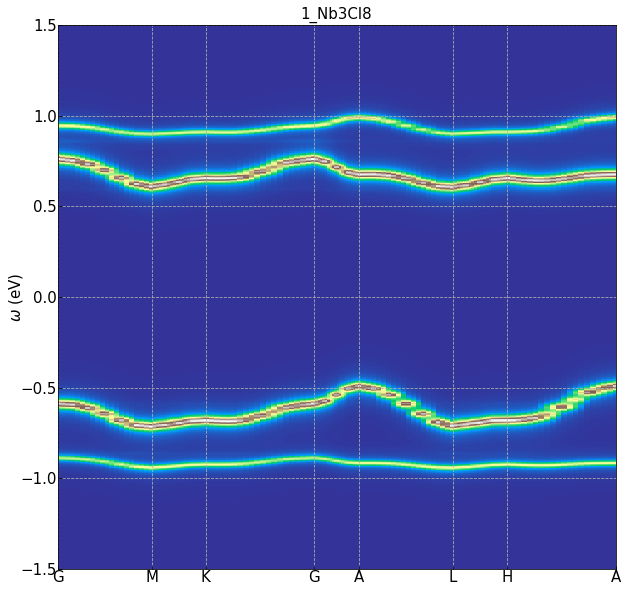

In [13]:
fig, ax = plt.subplots(figsize=(10,10))

plt.title(material[matid], fontsize=15)

ax.pcolormesh(xx, yy, A_spec, cmap=plt.get_cmap('terrain'), shading='auto', rasterized=True)
ax.set_ylabel(r'$\omega$ (eV)', fontsize=15, labelpad=-5) 

plt.xticks(ticks=labTicks, labels=lab, fontsize=15)
plt.yticks(fontsize=15)
ax.set_ylim((settings.en_min, settings.en_max))
ax.set_xlim(np.min(xx), np.max(xx))

ax.grid(which='major', axis='both', linestyle='--')
ax.grid(which='minor', axis='both', linestyle=':')
ax.tick_params(axis="both", direction="in", pad=1)

plt.show()